# CUARTO INFORME DE ASTROMETRIA
#### Baracchi, Marcos. Gmail: marcos.baracchi@mi.unc.edu.ar

### **1_Introducción**

En este informe se realizara **inferencia estadística** para **determinar los parametros** de la Función Luminocidad utilizando **Cadenas de Markov Monte Carlo (MCMC)**. Los algoritmos que se utilizaran para determinar los valores seran el **Metrópolis-Hastings** y el de **Gradiante Descendiente**.

### **2_Datos y Resultados**  

Los datos utilizados en el trabajo se fueron tomados del paper de **Balton et al. (2001)**, del cual se tomaron la magnitudes de las galaxias(M/$ Mpc^3 $), la luminosidad (galaxias/$ Mpc^3 $), y su correspondiente error superior e inferior de este ultimo.

#### **2.1_Ejercicio 1** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import scipy as sp
import numdifftools as nd

In [2]:
df = pd.read_csv("datos.csv") #cargamos y visualisamos los datos
df.head()

,MAG,PHI,error_inf,error_sup
0,-23.183,0.000003,0.000001,0.000006
1,-23.020,0.000005,0.000003,0.000011
2,-22.870,0.000017,0.000013,0.000026
3,-22.698,0.000035,0.000025,0.000044
4,-22.565,0.000082,0.000058,0.000105


A continuación, se graficaron los datos con su correspondiste error.

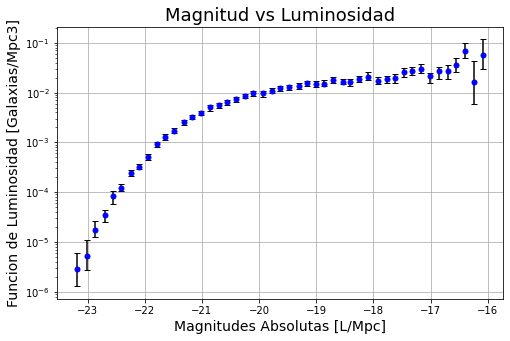

In [3]:
plt.figure(figsize=(8,5))
error_s =  df['error_sup'] - df['PHI']
error_i =  -df['error_inf'] + df['PHI']
plt.errorbar(df['MAG'], df['PHI'],  yerr = [error_i,error_s], fmt='ob',ms = 5,  capsize=3,  ecolor="k")
plt.xlabel('Magnitudes Absolutas [L/Mpc]',fontsize = 14) 
plt.ylabel('Funcion de Luminosidad [Galaxias/Mpc3]',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Luminosidad',fontsize = 18 )
plt.show()

#### **2.2_Ejercicio 2** 

Luego, se uso la funcion *Schechter* para modelar la curva visualizada anteriormente, la cual es funcion de la magnitud M y **depende de tres parametros** $ \phi_0 $, $ \alpha $ y $ M_0 $.

$$ \phi(M)dM = 0.4\log(10)\phi_010^{-0.4(M-M_0)(\alpha + 1)}\times\exp(-10^{-0.4(M-M_0)})dM $$

Se realizará una inferencia Bayesiana para obtener el ajuste del modelo paramétrico a los datos, que como el nombre lo indica, la inferencia estadı́stica se lleva a cabo como una aplicación del teorema de Bayes.

Si se tiene un conjunto de datos *d* que se puede describir por un modelo *m* con parámetros $\phi $, se quiere calcular el mejor modelo que puede dar lugar a esos datos, es decir, maximizar la probabilidad posterior de los parámetros dados los datos para un modelo, $ p(\phi|m,d) $. Ésta probabilidad se puede escribir gracias al Teorema de Bayes, como:

$$ p(\phi|m,d) = \frac{p(d|m,\phi)p(\phi|m)}{p(d|m)} $$

donde $ p(d|m,\phi) $ es el Likelihood, $ p(\phi|m) $  la función distribución de la probabilidad anterior (prior) y $p(d|m)$ la evidencia. Donde la *prior* se toma igual a 1 ya que el modelo esta fijo y la evidencia tambien por conveniencia.

In [4]:
def schechter(M,phi0,a0,M0): # defino la funcion schecheter
    lista = []
    for i in range(len(M)):
        p = 10**((-0.4*(M[i] - M0))*(a0 + 1))
        r = np.exp(-10**(-0.4*(M[i] -M0 )))
        y =y=0.4 * np.log(10) * phi0 * p * r
        lista.append(y)
    return(lista)

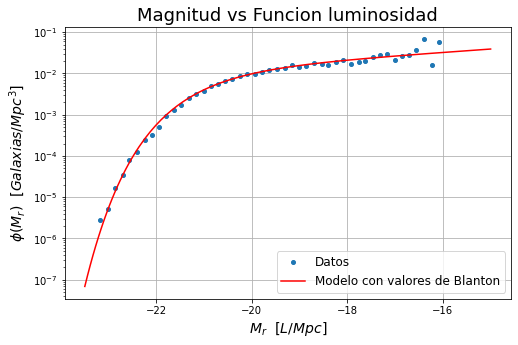

In [5]:
plt.figure(figsize=(8,5))
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
sx = np.linspace(-23.5, -15, 150)
sy = schechter(sx,0.0146,-1.20,-20.83) # estos valores son los obtenidos de Blanton et al. (2001).
plt.plot(sx,sy, color='red', label='Modelo con valores de Blanton')
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Funcion luminosidad',fontsize = 18 )
plt.legend(loc = 'lower right',fontsize = 12)
plt.show()

Los parámetros que se intentan determinar son $ \phi_0 $, $ \alpha $ y $ M_0 $. Para ello, se definieron primero las siguientes funciones:
- la función de ***likelihood*** $ \rightarrow $ mide la discripancia entre los valores de los datos y el modelo.
- la función de ***priors*** $ \to $ es el espacio de parametros en donde realizaremos la busqueda de estos.
- la función de ***probabilidad posterior*** $\to $ es la probabilidad de los datos dado el modelo $ p(\phi_i|m) $.

Antes, definimos los errores de los tados, ya que vamos a suponer que los mismos soy gaussianos, donde los datos estan centrados en la gaussiana. Hacemos esta suposición de los errores ya que este modo el calculo de el *likelihood* se tranforma en una expresión mas sencilla.

In [7]:
error_s =  df['error_sup'] - df['PHI']
error_i =  -df['error_inf'] + df['PHI']
sigma = np.abs((error_s + error_i)/2)
#sigma

In [8]:
def likelihood(M,phi,phi0,a0,M0,sigma):
    phi_model = schechter(M,phi0,a0,M0) # valor de phi calculado por el modelo 
    c = 1/(np.sqrt(2*np.pi)*sigma)
    w = (phi - phi_model)**2/((np.sqrt(2)*sigma))**2
    p = np.sum(w)                                        
    return(p)

In [9]:
def priors(phi0,a0,m0,philim,Alim,Mlim):
    if (philim[0]<= phi0) & (phi0 <= philim[1]) & (a0 >= Alim[0]) & (a0 <= Alim[1]) & (Mlim[0]<= m0) & (Mlim[1]>= m0):
        return 1 
    else:
        return 0 

In [10]:
def posteriori (m,f,phi0,a0,m0,sigma,philim,Alim,Mlim): # esto es el log de la posteriori
    post = likelihood(m,f,phi0,a0,m0,sigma) + np.log(priors(phi0,a0,m0,philim,Alim,Mlim))
    return (post)

Luego, para definir el espacio de parametros vamos a ver como estos afectan al modelo y lo vamos a realizar de manera grafica.

In [11]:
fi0 = np.linspace(0.001,0.040,10)
A0 = np.linspace(-3,0.,10)
m0 = np.linspace(-23,-19,10)
p = []
o = []
q = []
for i in range(10):        
    g = schechter(sx,fi0[i], -1.20, -20.83) # tengo q cambiar el likelihood por la schechter
    l = schechter(sx,0.0146, A0[i], -20.83)
    m = schechter(sx,0.0146, -1.20, m0[i])
    p.append(g)
    o.append(l)
    q.append(m)

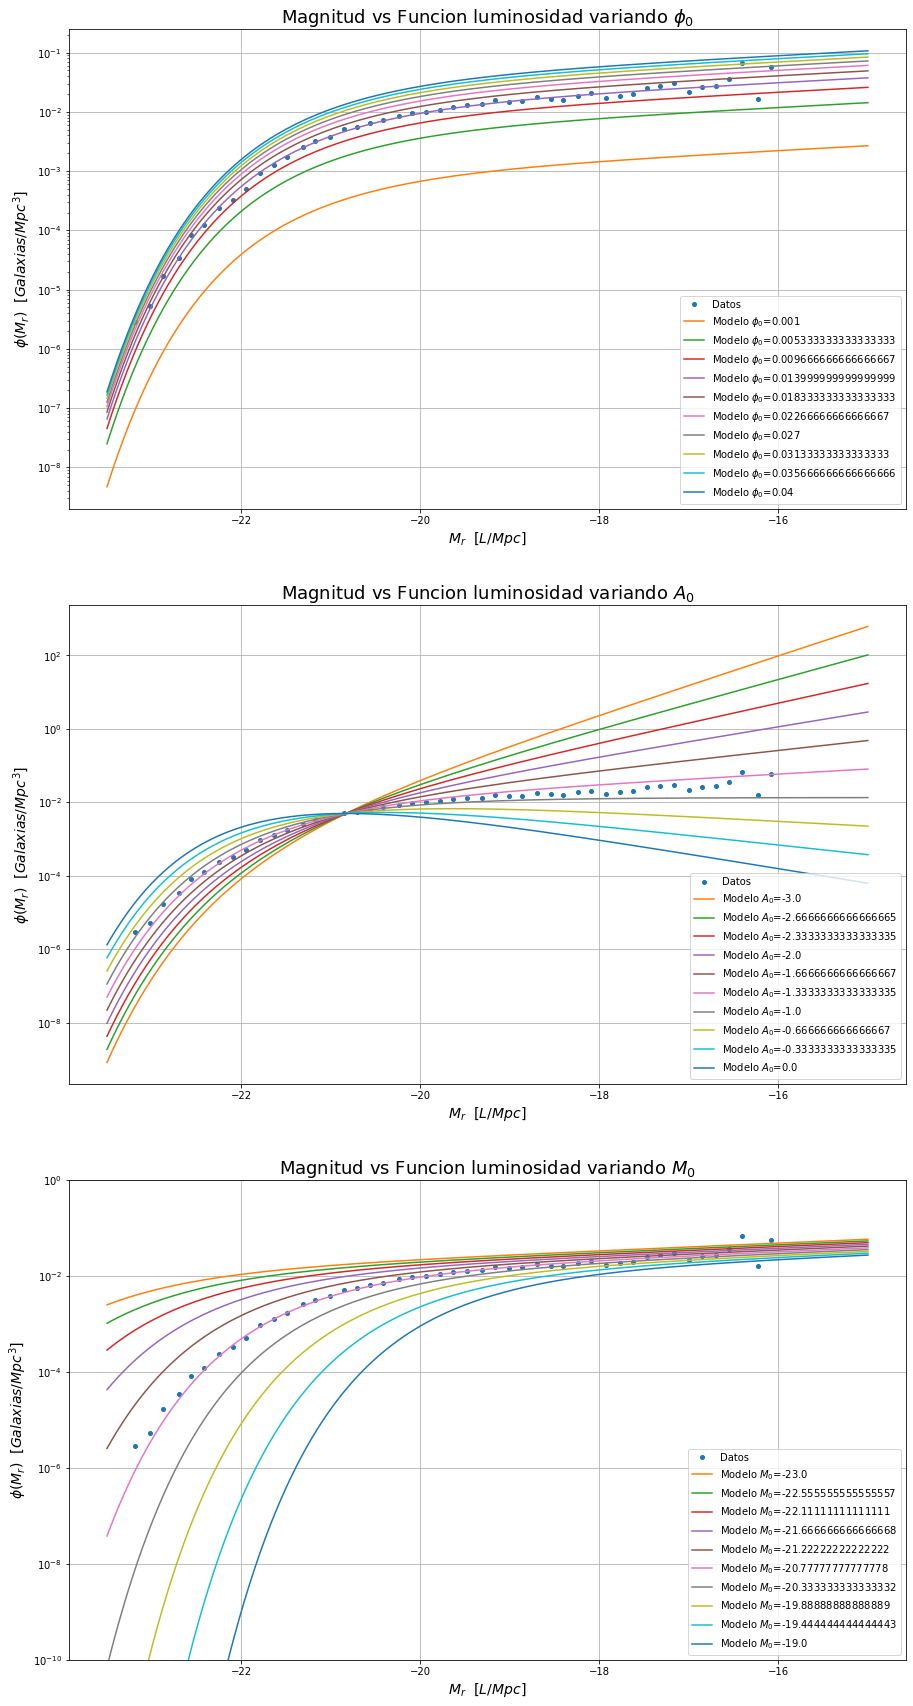

In [12]:
plt.figure(figsize=(15,30))
sx = np.linspace(-23.5, -15, 150)
#sy = schechter(sx,0.0146,-1.20,-20.83) # estos valores son los obtenidos de Blanton et al. (2001).

plt.subplot(3,1,1)
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
for i in range(10):
    plt.plot(sx,p[i], label=f"Modelo $ \phi_0$={fi0[i]}")
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Funcion luminosidad variando $\phi_0$',fontsize = 18 )
plt.legend(loc = 'best')

plt.subplot(3,1,2)
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
for i in range(10):
    plt.plot(sx,o[i], label=f"Modelo $ A_0 $={A0[i]}")
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Funcion luminosidad variando $ A_0$',fontsize = 18 )
plt.legend(loc = 'lower right')

plt.subplot(3,1,3)
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
for i in range(10):
    plt.plot(sx,q[i], label=f"Modelo $ M_0$={m0[i]}")
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.ylim(0.0000000001,1)
plt.grid()
plt.title('Magnitud vs Funcion luminosidad variando $M_0$',fontsize = 18 )
plt.legend(loc = 'best')

plt.show()

De estos graficos obtenemos los limites de los parametros, es decir, nuestro **espacio de parametros**. Se decidieron tomar los siguientes valores:

In [13]:
philim = [0.005,0.035]
Alim = [-1.66,-0.66]
Mlim = [-21.22,-20.33]

Ya que estos valores para los parametros encierran a todos los puntos de datos.

Si todo esta correctamente, la funcions postiriori deberia presentar un minimo(por construccion de la funcion *likelihood*) en los valores obtenidos por Baltom. Veamos si eso sucede.

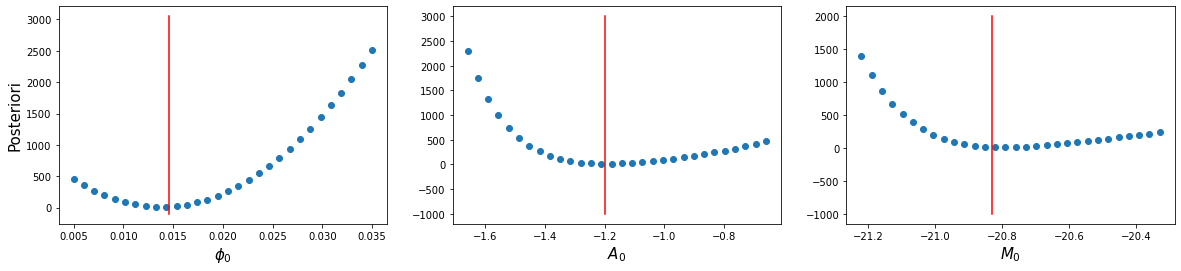

In [16]:
fi0c = np.linspace(0.005,0.035,30)
A0c = np.linspace(-1.66,-0.66,30)
m0c = np.linspace(-21.22,-20.33,30)
a = []
b = []
c = []
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
for i in range(30):
    a.append(posteriori (df['MAG'],df['PHI'],fi0c[i],-1.2,-20.83,sigma,philim,Alim,Mlim))
plt.plot(fi0c,a,'o')
plt.plot([0.0146,0.0146], [-100,3050],color="red")
#plt.ylim(0,300)
plt.xlabel('$\phi_0$',fontsize = 15)
plt.ylabel('Posteriori',fontsize = 15)

plt.subplot(1,3,2)
for i in range(30):
    b.append(posteriori (df['MAG'],df['PHI'],0.0146 ,A0c[i],-20.83,sigma,philim,Alim,Mlim))
plt.plot(A0c,b,'o')
plt.plot([-1.20,-1.20], [-1000,3000],color="red")
#plt.ylim(0,500)
plt.xlabel('$A_0$',fontsize = 15)

plt.subplot(1,3,3)
for i in range(30):
    c.append(posteriori (df['MAG'],df['PHI'],0.0146,-1.2,m0c[i],sigma,philim,Alim,Mlim))
plt.plot(m0c,c,'o')
plt.plot([-20.83,-20.83], [-1000,2000],color="red")
#plt.ylim(0,800)
plt.xlabel('$M_0$',fontsize = 15)

plt.show()

Vemos que en general sucede lo que esperabamos. En el caso de $ \alpha_0 $ encontremos una pequeña discrepancia, por lo que le prestaremos mas atencion a este parametro mas adelante.

Una ves que tenemos las funciones definidas y probadas, junto con en espacio de parametros a estudiar, vamos a definir una función del algoritmo de **Metrópolis-Hastings** para luego recorrer el espacio de parametros y encontrar los mejores valores.

In [14]:
def metropolis(m,f,phi0,a0,m0,N,philim,Alim,Mlim,sigma): #aca los phi0,a0 y m0 son valores iniciales 
 #de donde va a comensar el algoritmo
    param = np.zeros((N,3))
    if priors(phi0,a0,m0,philim,Alim,Mlim) == 1:
        param[0][0],param[0][1],param[0][2] = phi0,a0,m0
    else:
        return ('Los parametros no estan dentro de los valores permitidos')
        return(None)
    poste = []
    rl = []
    for i in range(N-1):
        h = posteriori (m,f, param[i][0],param[i][1],param[i][2],sigma,philim,Alim,Mlim)
        poste.append(h)
        param[i+1][0] = param[i][0] + ((np.random.rand()*2.0)-1.0)*((philim[1]-philim[0])/80)
        param[i+1][1] = param[i][1] + ((np.random.rand()*2.0)-1.0)*((Alim[1]-Alim[0])/80)
        param[i+1][2] = param[i][2] + ((np.random.rand()*2.0)-1.0)*((Mlim[1]-Mlim[0])/80)      
        #
        if priors(param[i+1][0],param[i+1][1],param[i+1][2],philim,Alim,Mlim) == 1:
            k = posteriori (m,f, param[i+1][0],param[i+1][1],param[i+1][2],sigma,philim,Alim,Mlim)
            r = h-k
            rl.append(r)  
        #r = np.exp(r)           
            if r >= 0:
                continue #acepto derecho
            else:
                r = np.exp(r)
                random = np.random.random()
                #print(r,random)
                if random < r:
                    #print('Acepta')
                    continue
                else:
                    #print('No Acepta')
                    param[i+1][0] = param[i][0] 
                    param[i+1][1] = param[i][1]
                    param[i+1][2] = param[i][2]
        else:
            param[i+1][0] = param[i][0] 
            param[i+1][1] = param[i][1]
            param[i+1][2] = param[i][2]
    return(poste,rl,param)

In [15]:
#metropolis(df['MAG'],df['PHI'],0.008,-0.7,-20.5,4000,philim,Alim,Mlim,sigma)[1]

Y ahora, vamos a realizar una caminata para visualizar a que regiones del espacio converge la cadena, donde los puntos de partida de la cadena se tomaron de forma arbitrarea.

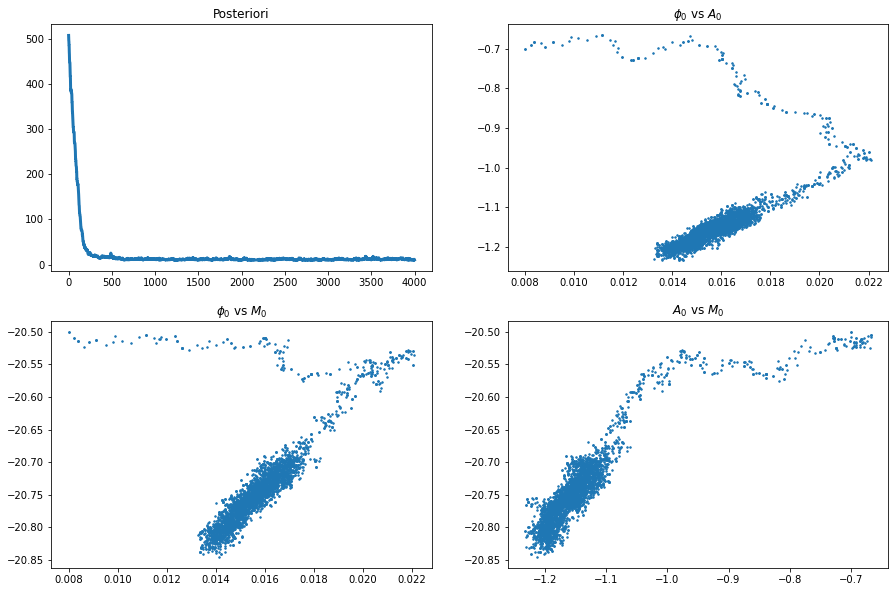

In [16]:
pos = metropolis(df['MAG'],df['PHI'],0.008,-0.7,-20.5,4000,philim,Alim,Mlim,sigma)[0]
par = metropolis(df['MAG'],df['PHI'],0.008,-0.7,-20.5,4000,philim,Alim,Mlim,sigma)[2]

plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(pos,'-',lw = 3)
plt.title('Posteriori')

plt.subplot(2,2,2)
plt.plot(par[:,0],par[:,1],'.',ms = 3)
plt.title('$ \phi_0 $ vs $ A_0 $')

plt.subplot(2,2,3)
plt.plot(par[:,0],par[:,2],'.',ms = 3)
plt.title('$\phi_0$ vs $M_0 $')

plt.subplot(2,2,4)
plt.plot(par[:,1],par[:,2],'.',ms = 3)
plt.title('$A_0$ vs $M_0 $')

plt.show()

Podemos hacer el **promedio** y la **desviacion estandar** de los parametros obtenidos **desde el paso 500** en adelante(ya que para esos valores de pasos el *likelihooh* ya es "estable".

In [17]:
phi0_mean = np.mean(par[700:,0])
phi0_desv = np.std(par[700:,0])
a0_mean = np.mean(par[700:,1])
a0_desv = np.std(par[700:,1])
M0_mean = np.mean(par[700:,2])
M0_desv = np.std(par[700:,2])
print('phi0_mean=',phi0_mean,'phi0_desv',phi0_desv)
print('a0_mean =',a0_mean,'a0_desv',a0_desv)
print('M0_mean =',M0_mean,'M0_desv ',M0_desv)

phi0_mean= 0.015393858429435716 phi0_desv 0.0009704084941397429
a0_mean = -1.1639580130941156 a0_desv 0.031199002271109597
M0_mean = -20.759668561330614 M0_desv  0.036024493494173734


#### **2.3_Ejercicio 3 y 4** 

Vamos a ver que obtenemos cuando realizamos un **mal o un buen mezclado** de las cadenas. Primero, vamos a tomar puntos de partida en nuestro espacio de parametros elegidos de forma aleatoria y en segundo lugar vamos a dividir a nuestro espacio  en cuadrantres y haremos partir a las cadenas del centro de los mismos.

Si ahora realizamos varias caminatas en simultaneo, partiendo desde puntos aleatorios tendiamos que ver que todas las cadenas convergen a un mismo punto (region, dado que no van directamente hacia en minimo si no que pueden recorrer el espacio de parametros por construcción).

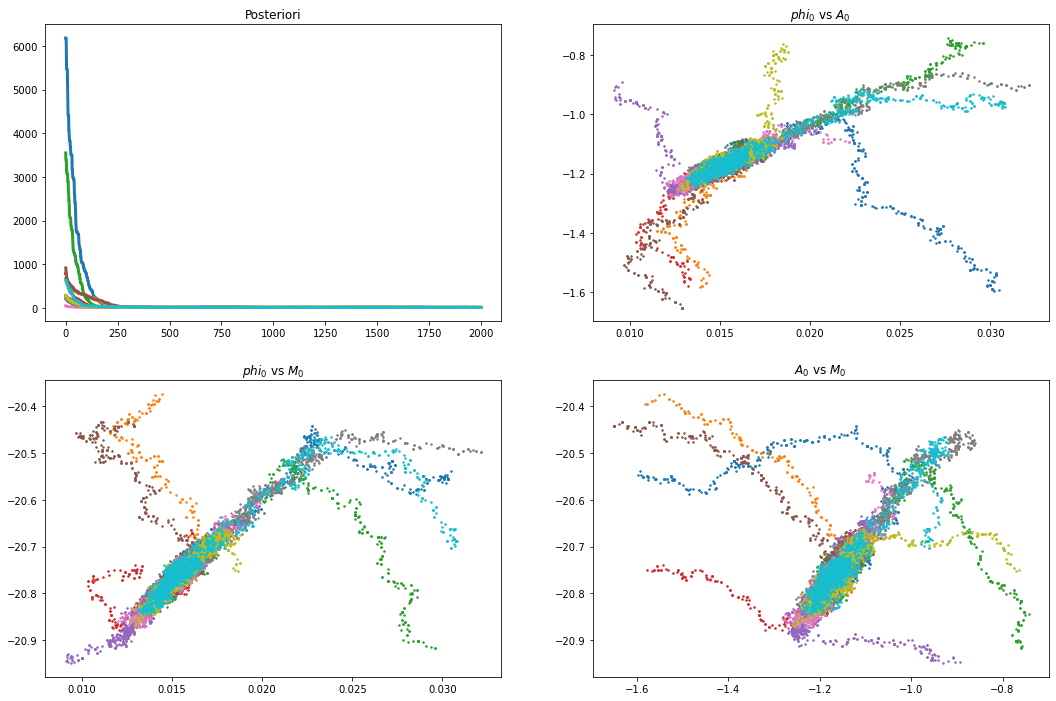

phi0_mean= 0.015345803813414162 phi0_desv 0.0010364014533568349
a0_mean = -1.166358439127022 a0_desv 0.03160567415631558
M0_mean = -20.762429116197396 M0_desv  0.04015616908495179


In [18]:
philim = [0.005,0.035]
Alim = [-1.66,-0.66]
Mlim = [-21.22,-20.33]
phi0_mean = []
a0_mean = []
M0_mean = []
parametros = []

plt.figure(figsize = (18,12))
for i in range(10):
    fi0 = np.random.random()*0.030+0.005
    a0 = np.random.random()*1-1.66
    m0 = np.random.random()*0.89-21.22
    pos = metropolis(df['MAG'],df['PHI'],fi0,a0,m0,2000,philim,Alim,Mlim,sigma)[0]
    par = metropolis(df['MAG'],df['PHI'],fi0,a0,m0,2000,philim,Alim,Mlim,sigma)[2]
    parametros.append(par)
    
    plt.subplot(2,2,1)
    plt.plot(pos,'-',lw = 3)
    #plt.ylim(0,1000,200)
    plt.title('Posteriori')    
    
    plt.subplot(2,2,2)
    plt.plot(par[:,0],par[:,1],'.',ms = 3)
    plt.title('$phi_0$ vs $A_0$ ')
    
    plt.subplot(2,2,3)
    plt.plot(par[:,0],par[:,2],'.',ms = 3)
    plt.title('$phi_0$ vs $M_0$ ')
       
    plt.subplot(2,2,4)
    plt.plot(par[:,1],par[:,2],'.',ms = 3)
    plt.title('$A_0$ vs $M_0$ ')
            
    phi0_mean.append(par[500:,0])
    a0_mean.append(par[500:,1])
    M0_mean.append(par[500:,2])
    
plt.show()

print('phi0_mean=',np.mean(phi0_mean),'phi0_desv',np.std(phi0_mean))
print('a0_mean =',np.mean(a0_mean),'a0_desv',np.std(a0_mean))
print('M0_mean =',np.mean(M0_mean),'M0_desv ',np.std(M0_mean))

Si ahora dividimos los intervalos de cada uno de los parametros en 2 partes y tomando el valor central de cada unos de esos sub-intervalos vamos a tener 8 cadenas que comenzaran de puntos seleccionados.

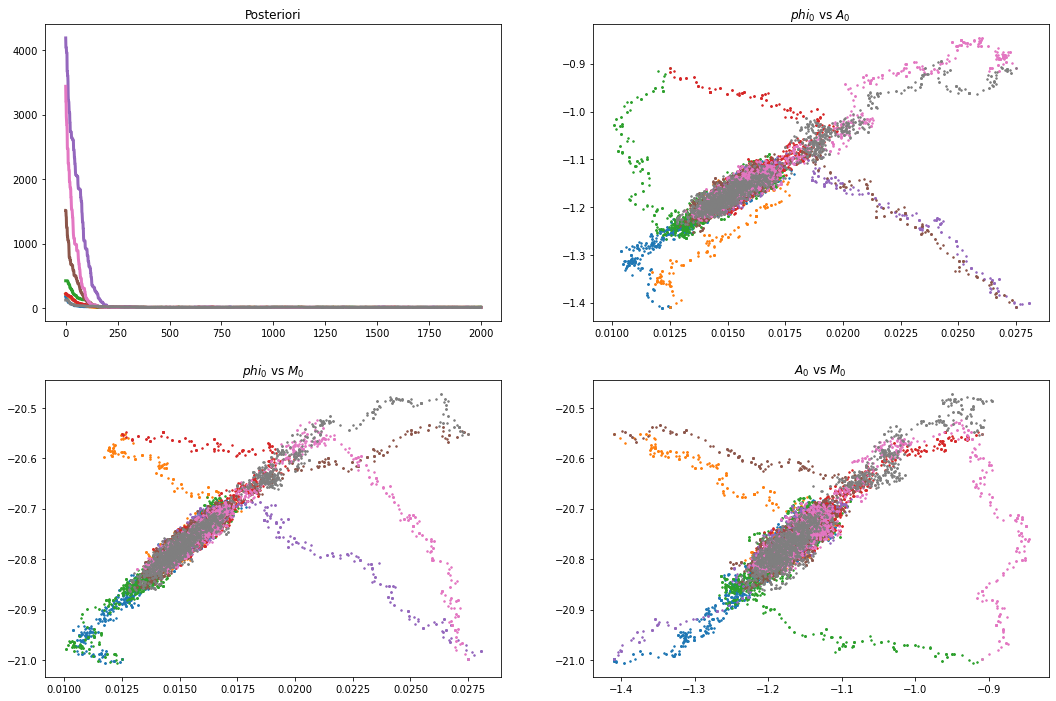

phi0_mean= 0.015345803813414162 phi0_desv 0.0010364014533568349
a0_mean = -1.166358439127022 a0_desv 0.03160567415631558
M0_mean = -20.762429116197396 M0_desv  0.04015616908495179


In [19]:
philim = [0.005,0.035]
Alim = [-1.66,-0.66]
Mlim = [-21.22,-20.33]
plt.figure(figsize = (18,12))

fi0 = [0.0125, 0.0275] 
a0 = [-1.41,-0.91]
m0 = [-20.9975,-20.5525]

pos1 = []
par1 = []

phi0_mean1 = []
a0_mean1 = []
M0_mean1 = []

for i in range(2):
    for j in range(2):
        for k in range(2):
            val = metropolis(df['MAG'],df['PHI'],fi0[i],a0[j],m0[k],2000,philim,Alim,Mlim,sigma)[0]
            para = metropolis(df['MAG'],df['PHI'],fi0[i],a0[j],m0[k],2000,philim,Alim,Mlim,sigma)[2]
            pos1.append(val)
            par1.append(para)
            
for i in range(8):                        
    plt.subplot(2,2,1)
    plt.plot(pos1[i],'-',lw = 3)
    #plt.ylim(0,1000,200)
    plt.title('Posteriori')

    plt.subplot(2,2,2)
    plt.plot(par1[i][:,0],par1[i][:,1],'.',ms = 3)
    plt.title('$phi_0$ vs $A_0$ ')
    plt.subplot(2,2,3)
    plt.plot(par1[i][:,0],par1[i][:,2],'.',ms = 3)
    plt.title('$phi_0$ vs $M_0$ ')

    plt.subplot(2,2,4)
    plt.plot(par1[i][:,1],par1[i][:,2],'.',ms = 3)
    plt.title('$A_0$ vs $M_0$ ')
    
    phi0_mean1.append(np.mean(par1[i][500:,0]))
    a0_mean1.append(np.mean(par1[i][500:,1]))
    M0_mean1.append(np.mean(par1[i][500:,2]))
    
plt.show()

print('phi0_mean=',np.mean(phi0_mean),'phi0_desv',np.std(phi0_mean))
print('a0_mean =',np.mean(a0_mean),'a0_desv',np.std(a0_mean))
print('M0_mean =',np.mean(M0_mean),'M0_desv ',np.std(M0_mean))

Ahora, para visualizar la diferencia entre ambos mezclados vamos a graficar como van variando los valores de los parametros en funcion de los pasos para cada una de las cadenas. Tenemos que ver que el buen mezclado comienza sus cadenas con valores diferentes entre si y bien distribuidos en el espacio de parametros mientras que el mal mezclado no.

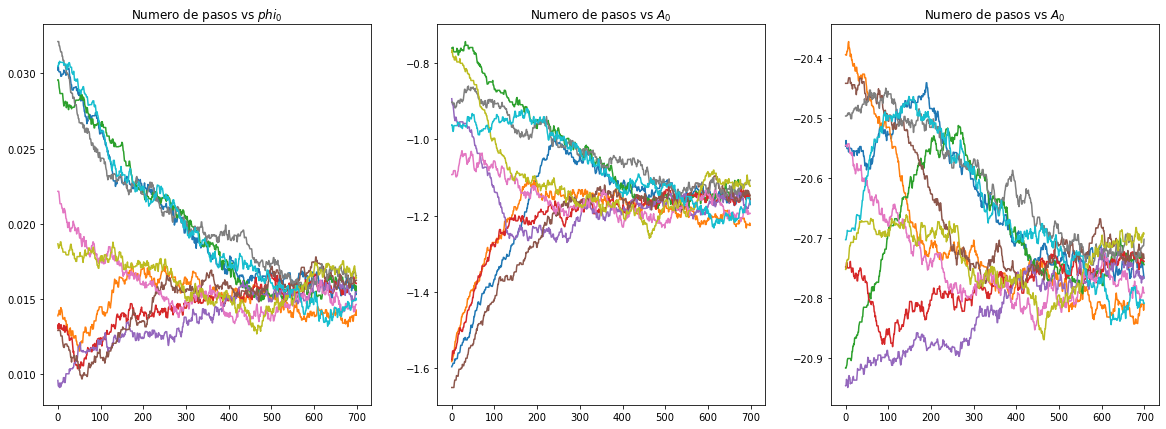

In [20]:
plt.figure(figsize = (20,7))
for i in range(10):
    plt.subplot(1,3,1)
    plt.plot(parametros[i][:700,0],'-',ms = 1)
    plt.title('Numero de pasos vs $phi_0$ ')
    plt.subplot(1,3,2)
    plt.plot(parametros[i][:700,1],'-',ms = 1)
    plt.title('Numero de pasos vs $A_0$ ')
    plt.subplot(1,3,3)
    plt.plot(parametros[i][:700,2],'-',ms = 1)
    plt.title('Numero de pasos vs $A_0$ ')
    
plt.show()

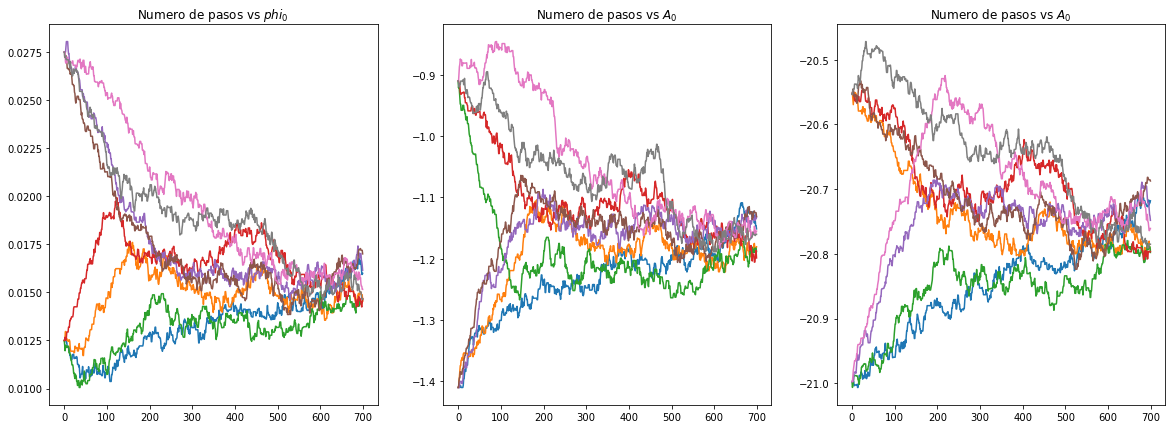

In [21]:
plt.figure(figsize = (20,7))
for i in range(8):
    plt.subplot(1,3,1)
    plt.plot(par1[i][:700,0],'-',ms = 1)
    plt.title('Numero de pasos vs $phi_0$ ')
    plt.subplot(1,3,2)
    plt.plot(par1[i][:700,1],'-',ms = 1)
    plt.title('Numero de pasos vs $A_0$ ')
    plt.subplot(1,3,3)
    plt.plot(par1[i][:700,2],'-',ms = 1)
    plt.title('Numero de pasos vs $A_0$ ')
    
plt.show()

Donde en las ultimas dos celdas vamos la diferencia entre un buen mezclado de cadenas y un mal mezclado.

#### **2.4_Ejercicio 5** 

El metodo del **Gradiante descendiente** nos permite encontrar los valores de los parametros que minimicen los valores de la función *posteriori* de manera mas directa que el algoritmo de Metrópolis-Hastings, ya que este no recorre el espacio de parametros tal cual lo hacia el anterior.

Defino primero la funcion *dir_grad* que va a ser la derivada en los parametros de la función posteriori dividido el modulo del gradiante, la cual me va  a dar la dirección en la cual me tengo que mover para encontrer el minimo de la función.

In [22]:
M = df['MAG']
phi = df['PHI']

In [23]:
def dir_grad(M,phi,phi0,a0,M0,sigma):
    model = schechter(M,phi0,a0,M0)
    factor = - (phi - model)/(sigma**2)
    g = -0.4*(M - M0)
    
    der_phi = -np.sum(factor*model/phi0)
    der_a = -np.sum(factor*np.log(10)*g*model)
    der_m = -np.sum(factor*model*np.log(10)*0.4*(a0 + 1 - (10**g)))
    norma = np.sqrt(der_phi**2 + der_a**2 + der_m**2)
    
    ver_grad = np.zeros(3)
    ver_grad[0], ver_grad[1], ver_grad[2] = (der_phi/norma), (der_a/norma),(der_m/norma)
   
    grad = np.zeros(3)
    grad[0], grad[1], grad[2] = der_phi, der_a, der_m
    
    return(ver_grad,norma,grad,der_m)

Ahora, defino la función del gradiante descendiente, la cual es la que va a realizar la caminata por mi espacio de parametros.

In [24]:
def grad_des(M,phi,phi0,a0,m0,N,sigma):
    par = np.zeros((N,3))
    par[0][0],par[0][1],par[0][2] = phi0, a0, m0
   
    for i in range(N-1):
        ver_grad = dir_grad(M,phi,par[i][0],par[i][1],par[i][2],sigma)[0]
      
        par[i+1][0] = par[i][0] + ver_grad[0]*(2*10**-5) #phi (2*10**-5)
        par[i+1][1] = par[i][1] + ver_grad[1]*(2*10**-1) #alpha (2*10**-1)
        par[i+1][2] = par[i][2] + ver_grad[2]*(2*10**-3) #m0 (2*10**-3)
        
    return(par)

Si visualizamos lo obtenido de la función gradiante descendiente en un par de puntos de origin seleccionados arbitrareamente podemos obtener los siguientres graficos.

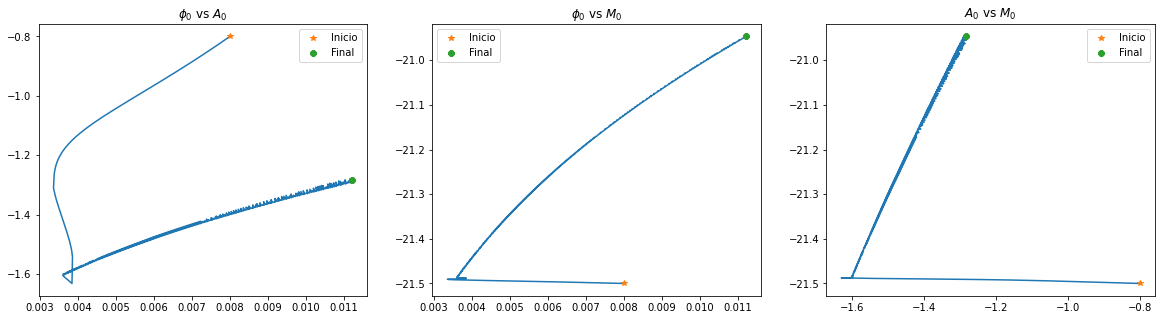

phi final = 0.011202689710369078
alpha final = -1.283331981606079
M0 final = -20.946470855237347


In [25]:
y0 = grad_des(M,phi,0.008,-0.8,-21.5,1000,sigma)

plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.plot(y0[:,0],y0[:,1],'-',ms = 2)
plt.plot(y0[0,0],y0[0,1],'*',ms = 6,label = 'Inicio')
plt.plot(y0[-1,0],y0[-1,1],'8',ms = 6,label = 'Final')
plt.title('$ \phi_0 $ vs $ A_0 $')
plt.legend(loc = 0)

plt.subplot(1,3,2)
plt.plot(y0[:,0],y0[:,2],'-',ms = 2)
plt.plot(y0[0,0],y0[0,2],'*',ms = 6,label = 'Inicio')
plt.plot(y0[-1,0],y0[-1,2],'8',ms = 6,label = 'Final')
plt.title('$ \phi_0 $ vs $ M_0 $')
plt.legend(loc = 0)

plt.subplot(1,3,3)
plt.plot(y0[:,1],y0[:,2],'-',ms = 2)
plt.plot(y0[0,1],y0[0,2],'*',ms = 6,label = 'Inicio')
plt.plot(y0[-1,1],y0[-1,2],'8',ms = 6,label = 'Final')
plt.title('$ A_0 $ vs $ M_0 $')
plt.legend(loc = 0)

plt.show()

print('phi final =',y0[-1,0])
print('alpha final =',y0[-1,1])
print('M0 final =',y0[-1,2])

Estos valores obtenidos no difieren en gran medida con los valores encontrados por Balton.

Si ahora realizamos varias cadenas tenemos que observar que con los suficientes pasos estas convergen a un mismo punto en el espacio de parametros.

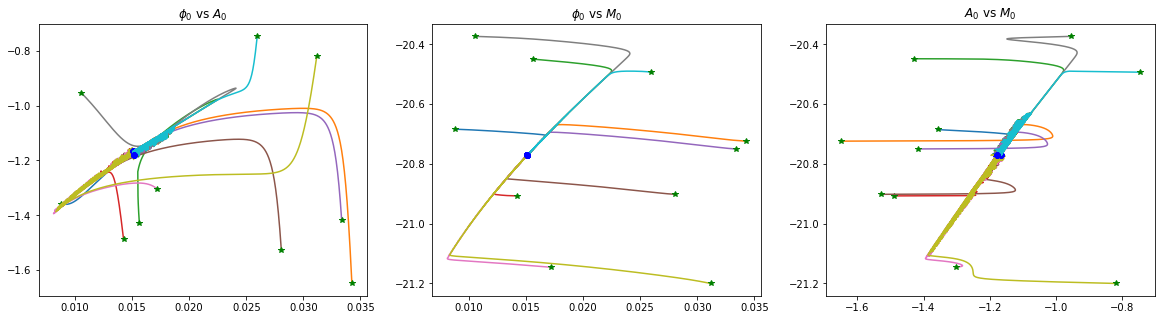

phi0_mean= 0.015120325770962034 phi0_desv= 1.2750518416604792e-05
a0_mean= -1.1727919628078525 a0_desv= 0.005116621967076498
m0_mean= -20.77096970897966 m0_desv= 5.058693591944422e-05


In [26]:
plt.figure(figsize = (20,5))
phi_final = []
a_final = []
m_final = []
for i in range(10):
    fi0 = np.random.random()*0.030+0.005
    a0 = np.random.random()*1-1.66
    m0 = np.random.random()*0.89-21.22
    y0 = grad_des(M,phi,fi0,a0,m0,3000,sigma)
    phi_final.append(y0[-1,0]), a_final.append(y0[-1,1]) , m_final.append(y0[-1,2])
    
    plt.subplot(1,3,1)
    plt.plot(y0[:,0],y0[:,1],'-',ms = 2)
    plt.plot(y0[0,0],y0[0,1],'*',color = 'green',ms = 6,label = 'Inicio')
    plt.plot(y0[-1,0],y0[-1,1],'8',color = 'b',ms = 6,label = 'Final')
    plt.title('$ \phi_0 $ vs $ A_0 $')
    
    
    plt.subplot(1,3,2)
    plt.plot(y0[:,0],y0[:,2],'-',ms = 2)
    plt.plot(y0[0,0],y0[0,2],'*',color = 'green',ms = 6,label = 'Inicio')
    plt.plot(y0[-1,0],y0[-1,2],'8',color = 'b',ms = 6,label = 'Final')
    plt.title('$ \phi_0 $ vs $ M_0 $')
    
    
    plt.subplot(1,3,3)
    plt.plot(y0[:,1],y0[:,2],'-',ms = 2)
    plt.plot(y0[0,1],y0[0,2],'*',color = 'green',ms = 6,label = 'Inicio')
    plt.plot(y0[-1,1],y0[-1,2],'8',color = 'b',ms = 6,label = 'Final')
    plt.title('$ A_0 $ vs $ M_0 $')
    
plt.show()

print('phi0_mean=',np.mean(phi_final),'phi0_desv=',np.std(phi_final))
print('a0_mean=',np.mean(a_final),'a0_desv=',np.std(a_final))
print('m0_mean=',np.mean(m_final),'m0_desv=',np.std(m_final))

En donde podemos ver que las desviaciones encontradas don todas de valores pequeños ya que todas las cadenas convergen al mismo valor de parametros.

### **3_Conclusiones**  

Los valores encontrados tanto por **Metrópolis-Hastings** como por **Gradiante descendiante** son comparables con los valores encontrados por Blaton et. al.(2001).
La diferencia entre algortimos es que el **Metrópolis-Hastings** nos da mas información acerca del entorno en donde se encuentran los minimos de la función y ademas esta tiene la posibilidad de que si se encuentra con un minimo secundario de la función poder salir de este, lo cual la de **Gradiante descendiente** por construcción no puede hacer.